In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from PIL import Image
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.densenet import DenseNet
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/densenet")
data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

# model

In [9]:
model = DenseNet(output_size=num_class, num_layer=169).to(device)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
DenseNet                                           --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    └─MaxPool2d: 2-2                              --
├─Sequential: 1-2                                  --
│    └─DenseBlock: 2-3                             --
│    │    └─ModuleList: 3-4                        335,040
│    └─TransitionBlock: 2-4                        --
│    │    └─ConvBnRelu: 3-5                        33,280
│    │    └─AvgPool2d: 3-6                         --
├─Sequential: 1-3                                  --
│    └─DenseBlock: 2-5                             --
│    │    └─ModuleList: 3-7                        919,680
│    └─TransitionBlock: 2-6                        --
│    

# training

In [11]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [12]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [13]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [14]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 818/818 [15:37<00:00,  1.15s/it]


epoch 1 : 0.03218905785984034


100%|██████████| 818/818 [03:31<00:00,  3.86it/s]


epoch 2 : 0.027812357247331176


100%|██████████| 818/818 [03:24<00:00,  4.00it/s]


epoch 3 : 0.02461574279673598


100%|██████████| 818/818 [03:24<00:00,  4.01it/s]


epoch 4 : 0.022403255276937574


100%|██████████| 818/818 [03:25<00:00,  3.98it/s]


epoch 5 : 0.020879288505726384


100%|██████████| 818/818 [03:28<00:00,  3.93it/s]


epoch 6 : 0.019363619128702103


100%|██████████| 818/818 [03:48<00:00,  3.58it/s]


epoch 7 : 0.018081256261318557


100%|██████████| 818/818 [04:01<00:00,  3.39it/s]


epoch 8 : 0.01709303938303243


100%|██████████| 818/818 [03:13<00:00,  4.23it/s]


epoch 9 : 0.015768330688258145


100%|██████████| 818/818 [03:13<00:00,  4.23it/s]

epoch 10 : 0.014754652634290363


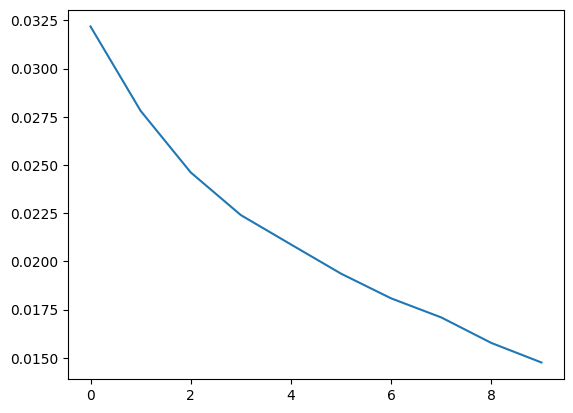

In [15]:
plt.plot(training_loss)

# inference

In [16]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [17]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [18]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [19]:
evaluator = ClassificationEvaluator(num_class, device)

In [20]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 819/819 [01:43<00:00,  7.89it/s]

[[3057  645  156  138  219  309  106   64   86   83]
 [  99 2140  122   56   46   11   77   21   29   22]
 [  20   76 1238   12   16   18    5    4   21   36]
 [  31   15    9 1765   42   34    2    0  194   20]
 [  74   58   52   70 2670   35   10   18   49   62]
 [ 312   42   43   42   44 1040    8   15   37   85]
 [  67  514  126   36   62    9  916  100   14   22]
 [ 110  123  204   20   93   26  165  987   36   56]
 [ 112   62   21  342   54  104   10   14 4011   91]
 [ 112   35   40   80   70  117    7   16  129 1256]]


In [21]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.6286243059839605
cavallo   : 0.8158597026305757
elefante  : 0.8561549100968188
farfalla  : 0.8357007575757576
gallina   : 0.8618463524854745
gatto     : 0.6235011990407674
mucca     : 0.4908896034297964
pecora    : 0.5423076923076923
ragno     : 0.8319850653391413
scoiattolo: 0.6745435016111708


In [22]:
per_class_acc.mean()

0.7161413090501155

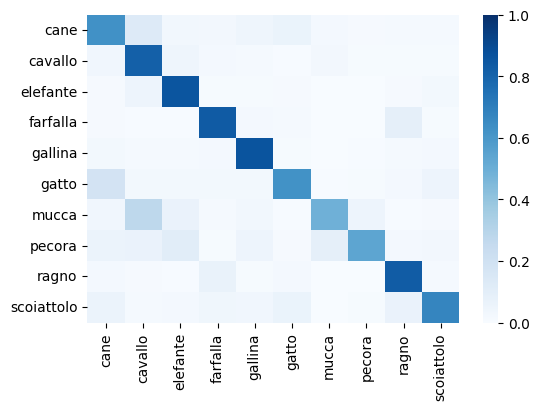

In [23]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [32]:
# image from internet
import requests
from io import BytesIO

demo_url = "http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcSFoiMCj_B7I2ML4tMYIbrcSgD9gBkp-G1JVfYz8R5xtL76jjcXyhY92BwcFNKCSxCU1NwmZ5XfIAO1VCF7WCM" # cow
# demo_url = "http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcRgs4mxH44aRwV3qnlSmBlnP2u4pEDu8gatItCeqvXEb3yUol302ClE9ujMszbxXiyPZopDy-3i9EzcjjLNdTI" # horse
img = Image.open(BytesIO(requests.get(demo_url).content))
img = test_preprocess(img).unsqueeze(0).to(device)

In [33]:
model.eval()
with torch.no_grad():
    prediction = model(img).detach().cpu()
    print(dataset.classes[prediction.argmax()])
    # print(dataset.classes[sample[1]])

mucca


In [26]:
model_path = artifact_path / 'densenet169.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'48.64MB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>